In [17]:
#Using generative AI to make images similar to a sample data set

In [3]:
from keras import utils

In [4]:
import keras

In [5]:
from diffusers import StableDiffusionPipeline


/opt/anaconda3/envs/blue_blob_GenAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from astroNN.datasets import galaxy10

In [7]:
from astroNN.models import Galaxy10CNN
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

In [8]:
from astroNN.shared.matplotlib import pylab_style
from keras.applications.resnet_v2 import ResNet50V2
from keras.utils import to_categorical

try:
    from keras.src.dtype_policies.dtype_policy import set_dtype_policy
except ModuleNotFoundError:
    from keras.dtype_policies.dtype_policy import set_dtype_policy

In [10]:
images, labels = galaxy10.load_data()

/Users/swapnaneeldey/.astroNN/datasets/Galaxy10_DECals.h5 was found!


In [11]:
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

In [12]:
labels.shape, images.shape

((17736, 10), (17736, 256, 256, 3))

===================Data Inspection===================


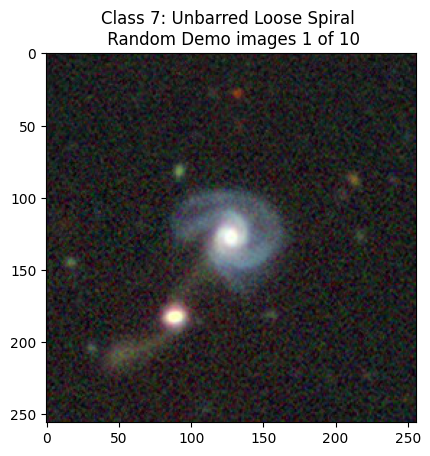

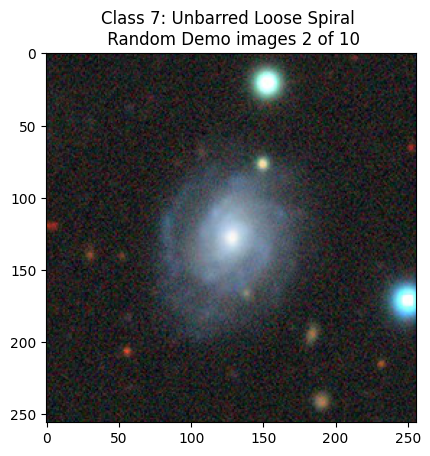

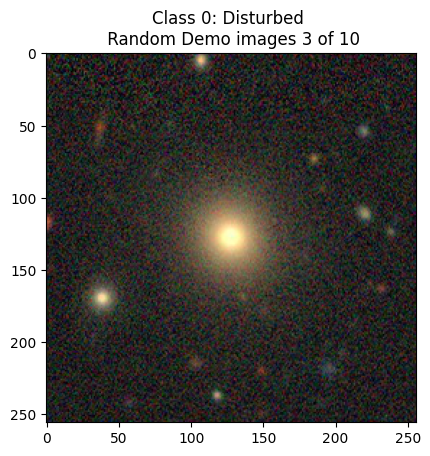

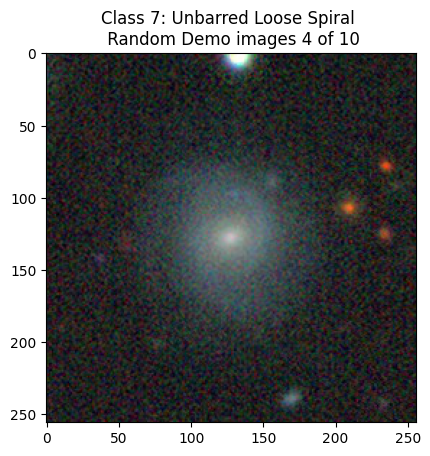

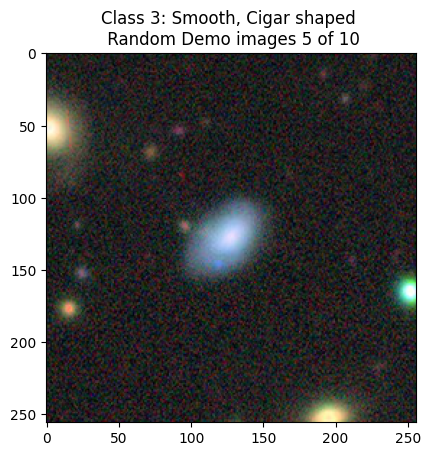

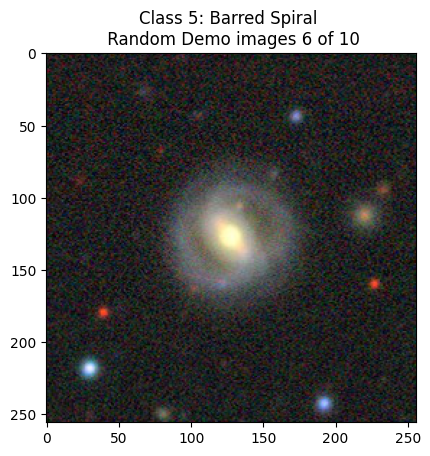

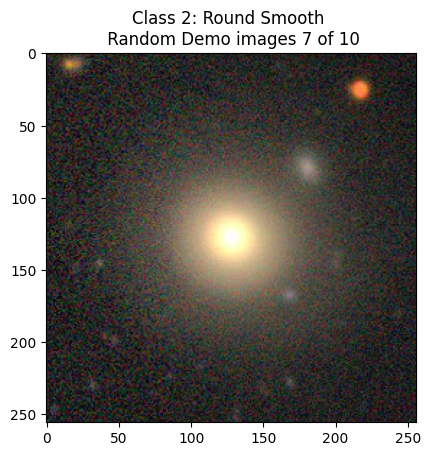

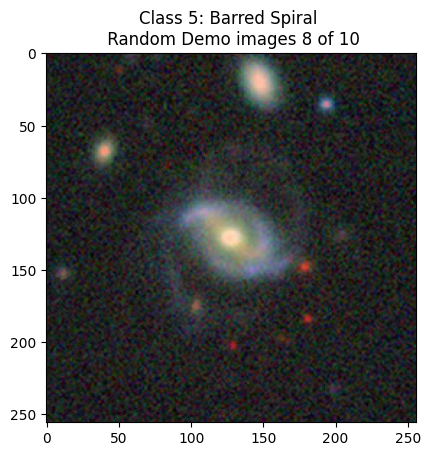

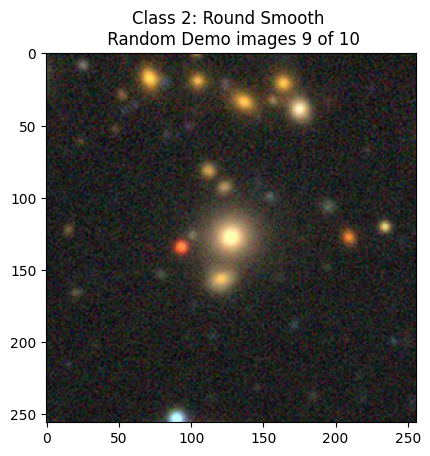

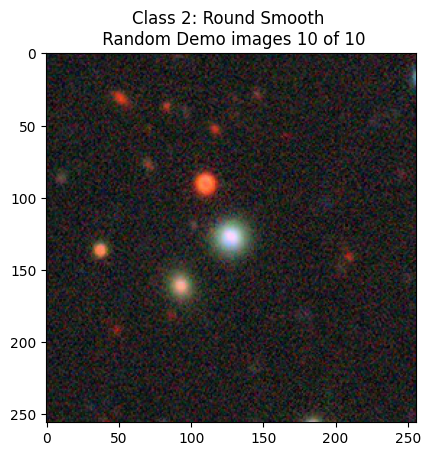

===============Data Inspection Finished===============


In [143]:
# Select 10 of the images to inspect
img = None
print("===================Data Inspection===================")
random_indices = np.random.randint(0, labels.shape[0], size=10) # Generate random indices *once*
for counter, i in enumerate(random_indices): # Iterate through the *random indices*
    img = plt.imshow(images[i])
    plt.title(
        f"Class {np.argmax(labels[i])}: {galaxy10cls_lookup(labels[i])} \n Random Demo images {counter+1} of 10"
    )
    plt.draw()
    plt.pause(2.0)
plt.close("all")
print("===============Data Inspection Finished===============")

In [13]:
# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

In [11]:
#access the first coloumn of labels array whose shape is (17736, 10)
len(np.where(labels[:, 2] == 1)[0])


2645

In [14]:
inx = np.random.choice(images.shape[0], 15000, replace=False)

In [174]:
images[inx]

array([[[[  3.,  35.,  24.],
         [ 31.,  58.,  27.],
         [ 31.,  48.,   3.],
         ...,
         [ 75.,  63.,  47.],
         [ 54.,  15.,  36.],
         [ 85.,  14.,  74.]],

        [[ 13.,  53.,  53.],
         [ 26.,  47.,  42.],
         [ 51.,  45.,  33.],
         ...,
         [ 65.,  67.,  62.],
         [ 73.,  41.,  65.],
         [ 59.,   0.,  47.]],

        [[  0.,  23.,  32.],
         [ 19.,  26.,  42.],
         [ 47.,  25.,  38.],
         ...,
         [ 40.,  46.,  58.],
         [ 64.,  34.,  62.],
         [ 59.,   0.,  35.]],

        ...,

        [[ 62.,  59.,  44.],
         [ 38.,  12.,   0.],
         [ 41.,  12.,   0.],
         ...,
         [ 58.,  47.,  90.],
         [ 74.,  32.,  78.],
         [ 63.,   1.,  38.]],

        [[ 19.,  36.,  26.],
         [ 49.,  45.,  34.],
         [ 37.,  20.,  10.],
         ...,
         [ 41.,  51.,  78.],
         [ 80.,  40.,  67.],
         [ 73.,   0.,   7.]],

        [[  0.,  17.,  12.],
       

In [ ]:
np.random.permutation(images.shape[0])

array([ 1416,  4316,   730, ...,  5213, 15295,  8975])

In [13]:
#making a subset of images, by taking in random images from the dataset
image_subset = images[inx]
label_subset = labels[inx]

KeyboardInterrupt: 

In [176]:
image_subset.shape, label_subset.shape  

((3000, 256, 256, 3), (3000, 10))

In [177]:
len(np.where(label_subset[:, 1] == 1)[0])

312

In [ ]:
label_sub = label_subset.astype(np.float32)
images_sub = image_subset.astype(np.float32)


In [179]:
images_sub /= 255.0

In [15]:
# Split the dataset into training set and testing set
train_idx, test_idx = inx[:12000], inx[12000:]
train_images, train_labels, test_images, test_labels = (
    images[train_idx],
    labels[train_idx],
    images[test_idx],
    labels[test_idx],
)

In [16]:
train_images /= 255.0
test_images /= 255.0

In [17]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape    

((12000, 256, 256, 3), (12000, 10), (3000, 256, 256, 3), (3000, 10))

In [18]:
base_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling="avg",
    classes=10,
    classifier_activation="softmax",
)

base_model.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = keras.layers.Dropout(0.2)(x)
x = keras.activations.relu(keras.layers.Dense(512)(x))
x = keras.layers.Dropout(0.2)(x)
x = keras.activations.relu(keras.layers.Dense(128)(x))
x = keras.layers.Dropout(0.2)(x)
outputs = keras.activations.softmax(keras.layers.Dense(10)(x))
model = keras.Model(inputs, outputs)
# Unfreeze the base model
base_model.trainable = True
opt = keras.optimizers.AdamW(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.fit(
    train_images,
    train_labels,
    batch_size=64,
    epochs=2,
    validation_data=(test_images, test_labels),
    shuffle=True,
)

Epoch 1/2
188/188 ━━━━━━━━━━━━━━━━━━━━ 1901s 10s/step - accuracy: 0.1581 - loss: 2.3222 - val_accuracy: 0.3837 - val_loss: 1.7935
Epoch 2/2
188/188 ━━━━━━━━━━━━━━━━━━━━ 1945s 10s/step - accuracy: 0.4983 - loss: 1.4615 - val_accuracy: 0.6257 - val_loss: 1.1036


In [19]:
def galaxy10_confusion(confusion_mat):
    """
    NAME:
        galaxy10_confusion
    PURPOSE:
        to plot confusion matrix
    INPUT:
        confusion_mat (ndarray): An integer 0-9
    OUTPUT:
        (string): Name of the class
    HISTORY:
        2018-Feb-11 - Written - Henry Leung (University of Toronto)
    """
    conf_arr = confusion_mat.astype(int)

    norm_conf = []
    a = np.max(conf_arr)
    for i in conf_arr:
        tmp_arr = []
        for j in i:
            tmp_arr.append(float(j) / float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(10, 10.5))
    ax = fig.gca()
    ax.set_title("Confusion Matrix for Galaxy10", fontsize=20)
    ax.set_aspect(1)
    ax.imshow(np.array(norm_conf), cmap=plt.get_cmap("Blues"), interpolation="nearest")

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(
                str(conf_arr[x][y]),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
            )

    ax.set_xticks(np.arange(width))
    ax.set_xticklabels([str(i) for i in range(width)], fontsize=20)
    ax.set_yticks(np.arange(height))
    ax.set_yticklabels([str(i) for i in range(width)], fontsize=20)
    ax.set_ylabel("Prediction", fontsize=20)
    ax.set_xlabel("Truth", fontsize=20)
    fig.tight_layout()

    return None

prediction_class = np.argmax(model.predict(test_images, batch_size=64), axis=1)
test_class = np.argmax(test_labels, axis=1)

# Prepare a confusion matrix
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for counter, i in enumerate(prediction_class):
    confusion_matrix[i, test_class[counter]] += 1



47/47 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step


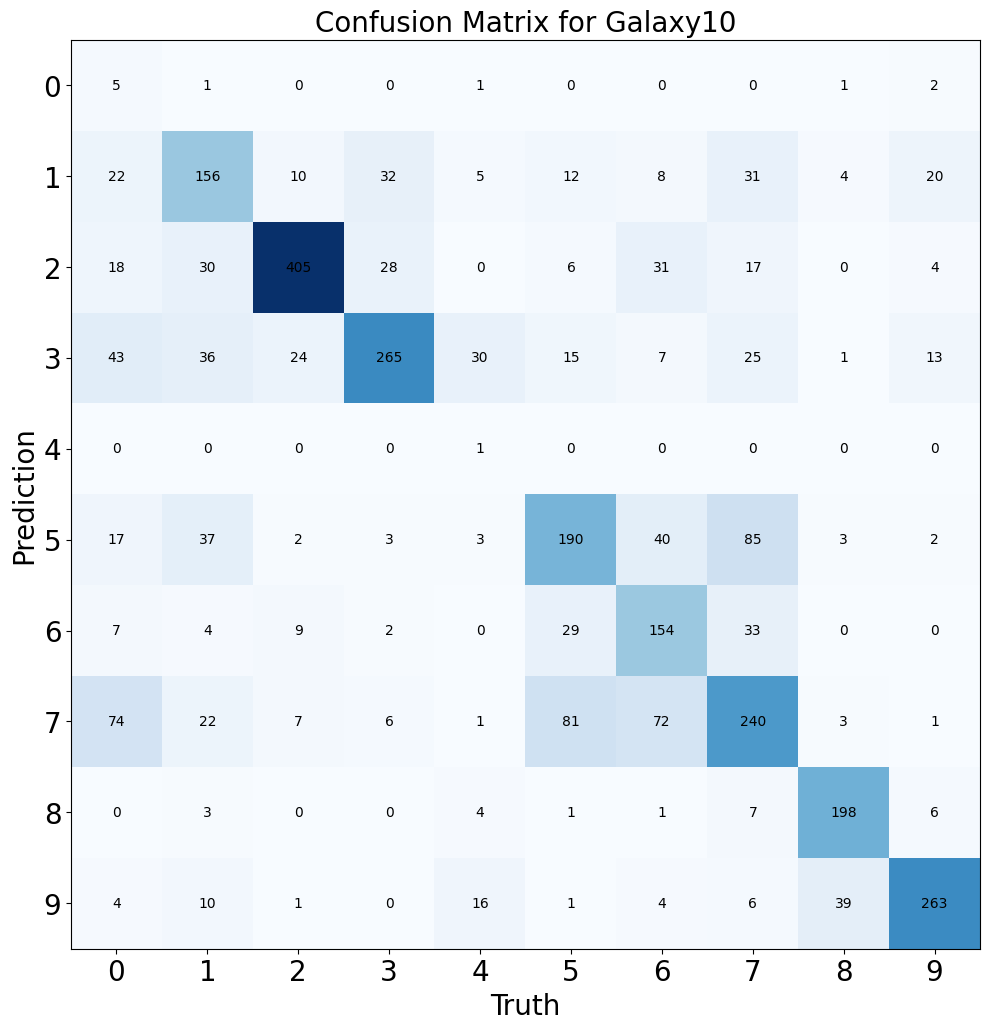

In [27]:
x = galaxy10_confusion(confusion_matrix)
#save the figure
plt.savefig('confusion_matrix.png')

In [144]:
images_all = images
images_50 = images[0:1000]

In [145]:
norm_images = images_50.astype('float32') / 255.0 # Normalize the images to [0, 1]

In [31]:
images_50.shape

(1000, 256, 256, 3)

In [9]:
few_shot_size = 50
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(norm_images, labels[0:1000], train_size=few_shot_size, random_state=42)

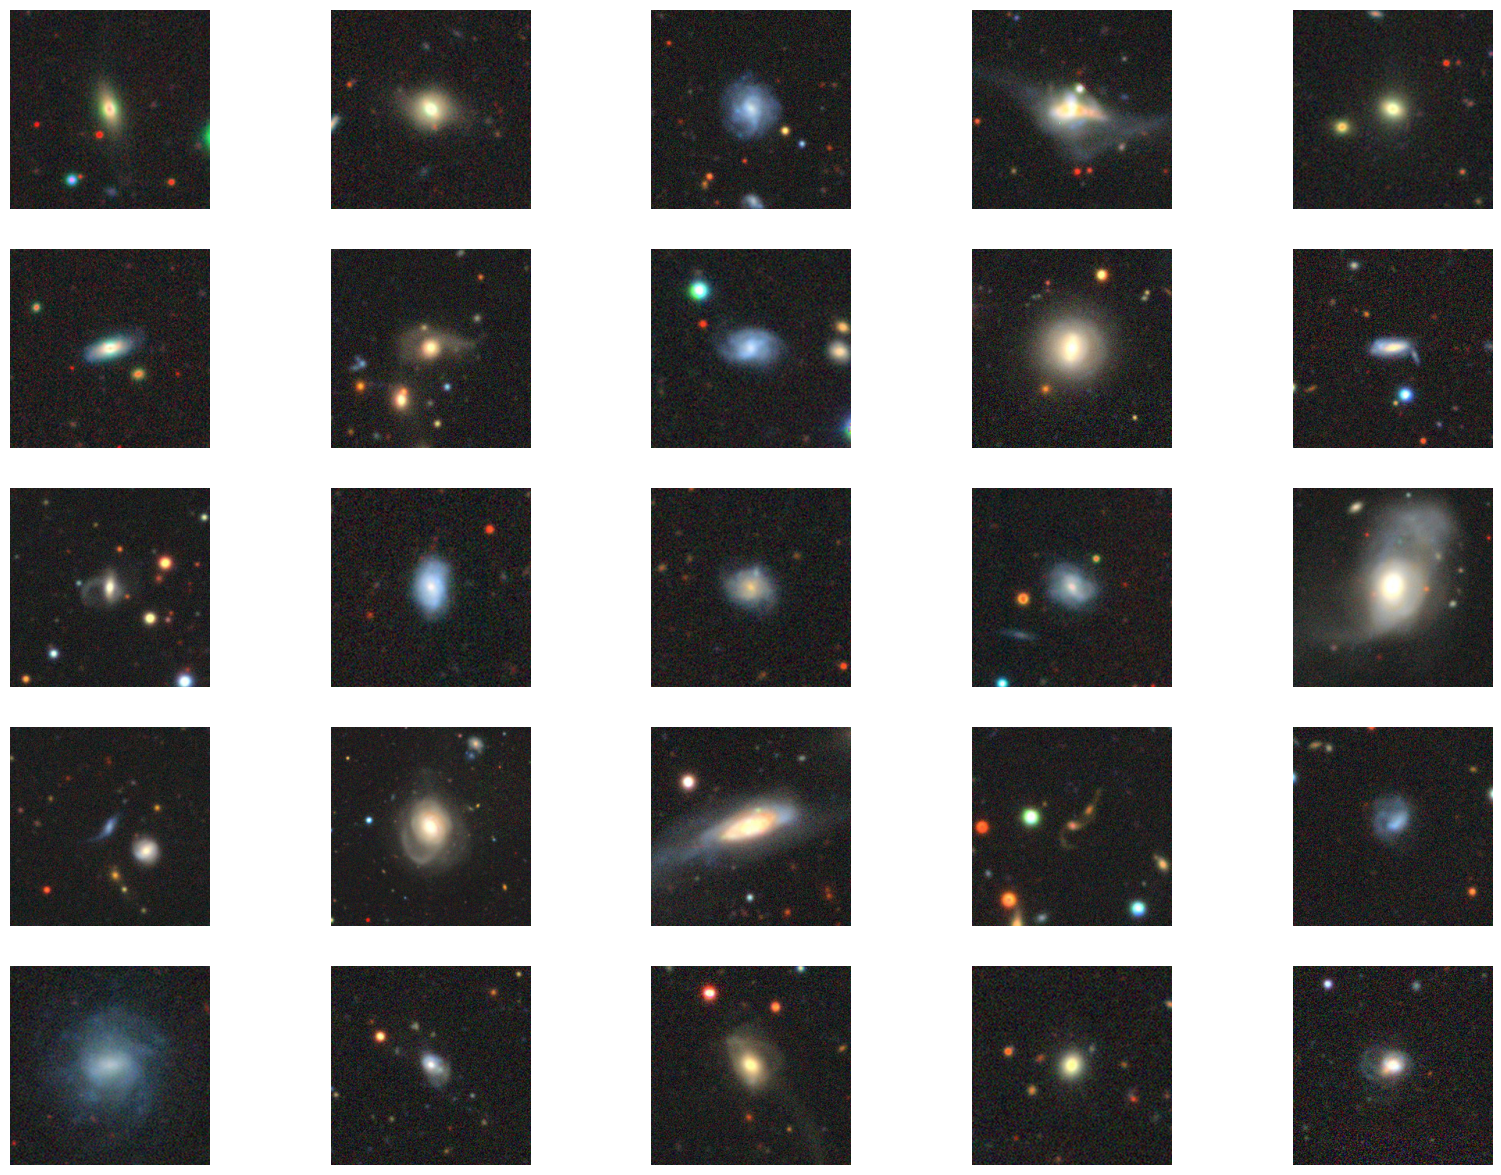

In [12]:
fig, axes = plt.subplots(5, 5, figsize=(20, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.axis("off")
plt.show()

In [13]:
X_train.shape

(50, 256, 256, 3)